# Predicting Price with Neighborhood

Goals

1> Build a model to predict apartment price based on neighbourhood
2> Encode categorical data to train linear model
3> Prevent Overfitting using regularization


In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


## Prepare Data

In [29]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Extracting neibhourhood from locations

    df["neighborhood"] =df["place_with_parent_names"].str.split("|", expand =True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    

    return df

In [30]:
# Use glob to import multiple files wothout repeating importing task 

files = glob("C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-*.csv")
files 


# Update wrangle with for loop  

frames = [] # for storing all the data frame in a single frame

for file in files:
    df = wrangle(file)
    frames.append(df)

In [31]:
len(frames)
type(frames[0])
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [32]:
# Concatenate Data frame (different frame into single frame)

df =pd.concat(frames, ignore_index=True)
df.shape

(6582, 17)

# Exploration Begins Now....

In [ ]:
# Extract neibhourhoods from location 

df["place_with_parent_names"].str.split("|", expand =True)[3]

# As we extract neighbour now we update our wrangle function 

In [33]:
# Check your work
assert df.shape == (6582, 17), f"`df` is the wrong size: {df.shape}."
assert (
    "place_with_parent_names" not in df
), 'Remember to remove the `"place_with_parent_names"` column.'

# Split Data 

In [34]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

# Build Model

In [35]:
# Baseline

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


In [41]:
# Transform using One Hot Encoder

X_train.head() # it is of categorical type which is not possible as regression model works on mathematical process


# Instantiate one hot encoder 
ohe = OneHotEncoder(use_cat_names=True)

# Fit model
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)

XT_train.shape

(6582, 57)

In [42]:
# Create Pipeline

model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)

model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [43]:
# Evaluate

y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39346.8


In [52]:
# Test for testset

X_test = wrangle("C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\housing-in-buenos-aires_data_buenos-aires-test-features.csv")["neighborhood"]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test


# Overfitting ....... (not a valid model)

0       191784.0
1       191784.0
2        97784.0
3       164448.0
4       105864.0
          ...   
1310    128728.0
1311    164912.0
1312    160856.0
1313    125448.0
1314    157240.0
Length: 1315, dtype: float64

In [50]:
X_test

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
2,sell,apartment,215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...,-34.588993,-58.400133,Recoleta
9,sell,apartment,341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...,-34.588044,-58.398066,Recoleta
12,sell,apartment,1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...,-34.623320,-58.397461,Monserrat
13,sell,apartment,105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...,-34.553897,-58.451939,Belgrano
17,sell,apartment,89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...,-34.628813,-58.472230,Villa del Parque
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,sell,apartment,112000.0,USD,1698188.80,112000.00,NaN,38.0,NaN,2947.368421,NaN,2.0,NaN,http://caballito.properati.com.ar/12d47_venta_...,-34.626138,-58.440472,Caballito
8563,sell,apartment,145000.0,USD,2198548.00,145000.00,NaN,40.0,NaN,3625.000000,1.0,2.0,NaN,http://palermo.properati.com.ar/10st9_venta_de...,-34.590708,-58.415568,Palermo
8572,sell,apartment,180000.0,USD,2729232.00,180000.00,65.0,60.0,2769.230769,3000.000000,NaN,3.0,3500.0,http://nunez.properati.com.ar/zoia_venta_depar...,-34.537851,-58.470731,Nuñez
8582,sell,apartment,119500.0,USD,1811906.80,119500.00,44.0,40.0,2715.909091,2987.500000,NaN,2.0,NaN,http://villa-crespo.properati.com.ar/10auv_ven...,-34.596715,-58.444045,Villa Crespo


In [53]:
# Communicate Result


# Extract intercept and cofficients

intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients


# Note that these are a little funky and tellling that it are kind of weird...


coefficients len: 57
[-4.66574255e+16 -4.66574255e+16 -4.66574255e+16 -4.66574255e+16
 -4.66574255e+16]


In [54]:
# Extract Feature Names of One Hot Encoder

feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names


features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


C:\Users\ujjwa\AppData\Roaming\Python\Python310\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [55]:
# Creating  Feature Important Series

feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita      -4.665743e+16
neighborhood_Villa Luro     -4.665743e+16
neighborhood_Caballito      -4.665743e+16
neighborhood_Constitución   -4.665743e+16
neighborhood_Once           -4.665743e+16
dtype: float64

In [56]:
#   Equation of Model

print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

    # Note that it is not Valid 

price = 4.665742554148654e+16
+ (-4.665742554136984e+16 * neighborhood_Chacarita)
+ (-4.665742554136899e+16 * neighborhood_Villa Luro)
+ (-4.665742554135781e+16 * neighborhood_Caballito)
+ (-4.665742554141131e+16 * neighborhood_Constitución)
+ (-4.665742554137032e+16 * neighborhood_Once)
+ (-4.665742554136422e+16 * neighborhood_Almagro)
+ (-4.6657425541321624e+16 * neighborhood_Palermo)
+ (-4.665742554137766e+16 * neighborhood_Flores)
+ (-4.665742554132209e+16 * neighborhood_Belgrano)
+ (-4.665742554138204e+16 * neighborhood_Liniers)
+ (-4.665742554136109e+16 * neighborhood_Villa Crespo)
+ (-4.665742554137896e+16 * neighborhood_San Cristobal)
+ (-4.6657425541375464e+16 * neighborhood_Congreso)
+ (-4.665742554135325e+16 * neighborhood_Saavedra)
+ (-4.665742554137993e+16 * neighborhood_Balvanera)
+ (-4.665742554139978e+16 * neighborhood_Parque Avellaneda)
+ (-4.665742554129475e+16 * neighborhood_Recoleta)
+ (-4.6657425541362104e+16 * neighborhood_San Telmo)
+ (-4.665742554132568e+16 * ne

# CURSE OF DIMENSIONALITY

In [58]:
# Linear model get panic over multiple dimensions and sometimes get shot out to different pridicte points which are unrealistic to prevent this case , we use ridge we prevent overfitting as by putting penalty on model to be cofficient neare to 0...

# Reconstruction pipeline

model2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model2.fit(X_train,y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [59]:
y_pred_training = model2.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [60]:
# Test for testset

X_test = wrangle("C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\housing-in-buenos-aires_data_buenos-aires-test-features.csv")["neighborhood"]
y_pred_test = pd.Series(model2.predict(X_test))
y_pred_test


0       191265.428077
1       191265.428077
2        98232.051308
3       165478.855330
4       105929.146473
            ...      
1310    127777.538197
1311    164459.057906
1312    161355.968734
1313    124801.695821
1314    156960.975224
Length: 1315, dtype: float64

In [63]:

# Extract intercept and cofficients

intercept = model2.named_steps["ridge"].intercept_
coefficients = model2.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients


# Note that this time is a little acceptable and be a kind of valid coefficients


coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [64]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head() # now it seeems a valid model prediction 

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

# Bar Charts

Text(0.5, 1.0, 'Feature Importance for Apartment Prices')

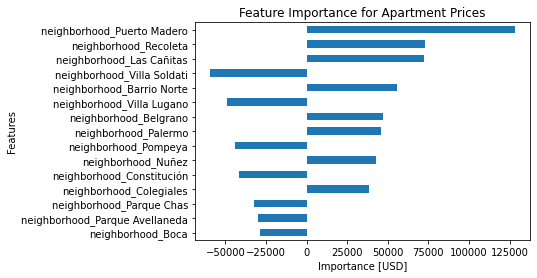

In [70]:
# Feature Importance Bar chart

# Sort coeff
feat_imp.sort_values(key= abs) # largest coefficient in tails

# To get most influential one 
feat_imp.sort_values(key= abs).tail(15)

#plot the most influential using bar 
feat_imp.sort_values(key= abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Feature Importance for Apartment Prices")


Looking at this bar chart, we can see that the poshest neighborhoods in Buenos Aires like Puerto Madero and Recoleta increase the predicted price of an apartment, while more working-class neighborhoods like Villa Soldati and Villa Lugano decrease the predicted price.
